In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import os
import pickle
import json
import cv2
import re

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# create giant dictionary for all data
data_dir = '../facebook_challenge_data/'
model_dir = '.'

# load data and print sizes
def get_dict(path):
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    return {datum['id'] : datum for datum in data}


train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

8500
500
1000


In [4]:
# transform from json dictionaries to dataset
def get_text_data(dictionary):
    return [(datum['text'], datum['label']) for datum in dictionary.values()]

train_data = get_text_data(train_dict)
val_data = get_text_data(val_dict)
# test_list = get_text_data(test_dict)

In [14]:
# make the dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUMBER_OF_WORDS = 20000
MAX_SEQ_LEN = 50

# training
texts, labels = zip(*train_data)
print('Longest training sequence length:', max([len(t.split()) for t in texts]))

tokenizer = Tokenizer(num_words=MAX_NUMBER_OF_WORDS, filters='\t\n', lower=True)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

y_train = np.asarray(labels)
print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

# validation
val_texts, val_labels = zip(*val_data)

val_sequences = tokenizer.texts_to_sequences(val_texts) # apply train tokenizer
x_val = pad_sequences(val_sequences, maxlen=MAX_SEQ_LEN)
y_val = np.asarray(val_labels)

Longest training sequence length: 70
Found 12644 unique tokens.
Shape of data tensor: (8500, 50)
Shape of label tensor: (8500,)


In [6]:
# embedding layer
from tensorflow.keras.layers import Embedding
EMBEDDING_DIM = 100

# map word to embedding
embeddings_index = {}
for line in open(os.path.join('..', 'glove.twitter.27B.100d.txt')):
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

# create embedding matrix (words without embeddings get zero embeddings)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

In [17]:
# validation on validation set
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(150))
# model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history = model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1264500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 1,415,251
Trainable params: 150,751
Non-trainable params: 1,264,500
_________________________________________________________________
None
Train on 8500 samples, validate on 500 samples
Epoch 1/10
8500/8500 [==============================] - 4s 495us/sample - loss: 0.6250 - accuracy: 0.6605 - val_loss: 0.7180 - val_accuracy: 0.5360
Epoch 2/10
8500/8500 [==============================] - 2s 180us/sample - loss: 0.5903 - accuracy: 0.6928 - val_loss: 0.7650 - val_accuracy: 0.5300
Epoch 3/10
8500/8500

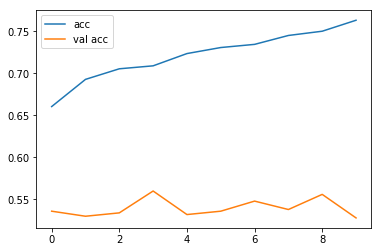

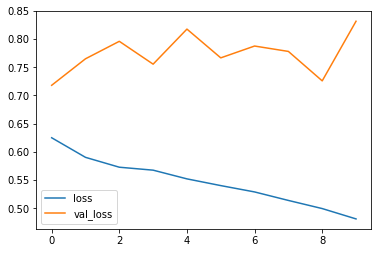

In [21]:
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [22]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

val_texts, val_labels = zip(*val_data)

val_sequences = tokenizer.texts_to_sequences(val_texts) # apply train tokenizer
x_val = pad_sequences(val_sequences, maxlen=MAX_SEQ_LEN)
y_val = np.asarray(val_labels)

# get AUROC
preds = model.predict(x_val)
print('Test AUROC:', roc_auc_score(y_val, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds >= 0.5] = 1
preds_bin[preds < 0.5] = 0
print('Val acc:', accuracy_score(y_val, preds_bin))

# get F1
print('Val F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Val Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Val Recall:', recall_score(y_val, preds_bin, zero_division=1))

Test AUROC: 0.63044
Val acc: 0.528
Val F1: 0.23376623376623376
Val Precision: 0.6206896551724138
Val Recall: 0.144


In [23]:
model.save(model_dir + 'fb_lstm.h5')

# Try mmhs150k trained model

In [12]:
from tensorflow.keras.models import load_model

model = load_model('../fcm_replication/models/lstm.h5')

In [15]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

val_texts, val_labels = zip(*val_data)

val_sequences = tokenizer.texts_to_sequences(val_texts) # apply train tokenizer
x_val = pad_sequences(val_sequences, maxlen=MAX_SEQ_LEN)
y_val = np.asarray(val_labels)

# get AUROC
preds = model.predict(x_val)
print('Test AUROC:', roc_auc_score(y_val, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds >= 0.5] = 1
preds_bin[preds < 0.5] = 0
print('Val acc:', accuracy_score(y_val, preds_bin))

# get F1
print('Val F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Val Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Val Recall:', recall_score(y_val, preds_bin, zero_division=1))

Test AUROC: 0.49477600000000005
Val acc: 0.51
Val F1: 0.21221864951768488
Val Precision: 0.5409836065573771
Val Recall: 0.132
